In [1]:
import os, sys, re
import subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pickle
import matplotlib.pyplot as plt

/opt/conda/lib/python3.8/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [2]:
year = "2017"
name = "fatjetkin"

with open('xsec.json') as f:
    xs = json.load(f)

with open('pmap.json') as f:
    pmap = json.load(f)
    
with open('lumi.json') as f:
    lumis = json.load(f)

indir = "outfiles-plots-old3/"
infiles = subprocess.getoutput("ls "+indir+year+"_*.coffea").split()
outsum = processor.dict_accumulator()


In [3]:
started = 0 
for filename in infiles:

    print("Loading "+filename)

    if os.path.isfile(filename):
        out = util.load(filename)

        if started == 0:
            outsum[name] = out[name]
            outsum['sumw'] = out['sumw']
            started += 1
        else:
            outsum[name].add(out[name])
            outsum['sumw'].add(out['sumw'])

        del out

Loading outfiles-plots-old3/2017_dask_JetHTData.coffea
Loading outfiles-plots-old3/2017_dask_QCD.coffea


In [4]:
scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}

outsum[name].scale(scale_lumi, 'dataset')
templates = outsum[name].group('dataset', hist.Cat('process', 'Process'), pmap)

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:376: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f097814ce20>
  warnings.warn(


In [5]:
def qcd_proc(h,procs):
    ddbbins = np.linspace(0,1,25)
    x = []
    y = []
    
    for p in procs:
        x += [ddbbins]
        y += [h.integrate('dataset',p).values()[()]]
    plt.hist(x=x,bins=ddbbins,weights=y,stacked=True,label=procs)
    plt.yscale('log')
    plt.legend(frameon=False,bbox_to_anchor=[1.1, 1])

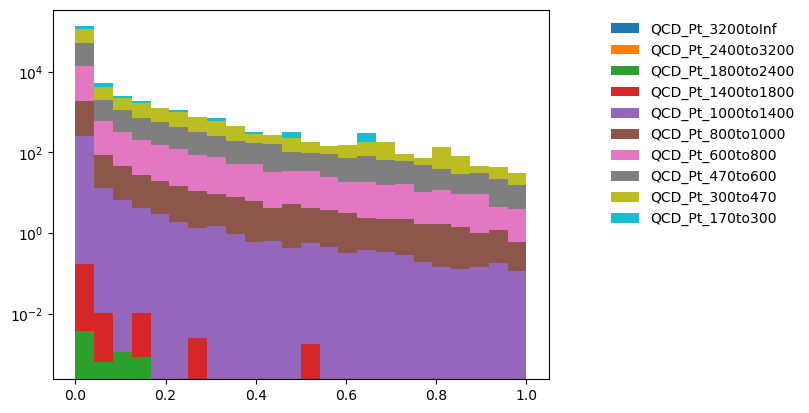

In [6]:
qcdpt =  ['QCD_Pt_3200toInf',
          'QCD_Pt_2400to3200',
          'QCD_Pt_1800to2400',
          'QCD_Pt_1400to1800',
          'QCD_Pt_1000to1400',
          'QCD_Pt_800to1000',
          'QCD_Pt_600to800',
          'QCD_Pt_470to600',
          'QCD_Pt_300to470',
          'QCD_Pt_170to300',
          #'QCD_Pt_120to170'
          ]

qcd_proc(outsum[name].sum('pt1','msd1').integrate('region','signal-vbf'),qcdpt)

In [7]:
templates_ggf = templates.integrate('region','signal-ggf').integrate('process','QCD').sum('pt1')
templates_vbf = templates.integrate('region','signal-vbf').integrate('process','QCD').sum('pt1')

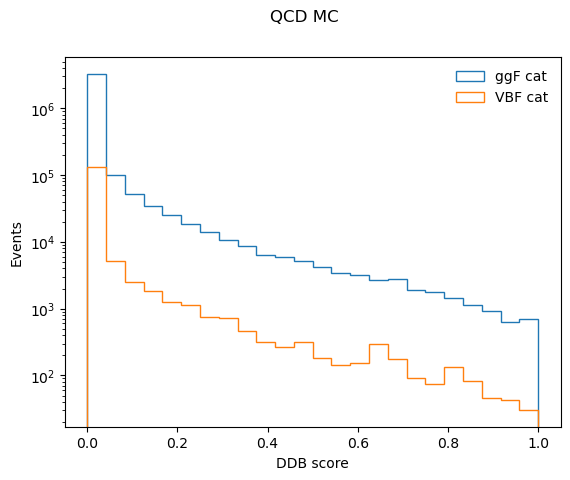

In [8]:
ddbbins = np.linspace(0,1,25)
plt.hist(x=ddbbins,weights=templates_ggf.sum('msd1').values()[()],bins=ddbbins,histtype='step',label='ggF cat');
plt.hist(x=ddbbins,weights=templates_vbf.sum('msd1').values()[()],bins=ddbbins,histtype='step',label='VBF cat');
plt.yscale('log')
plt.ylabel('Events')
plt.xlabel('DDB score')
plt.suptitle('QCD MC')

plt.legend(frameon=False)

<AxesSubplot: xlabel='Jet $m_{sd}$ [GeV]', ylabel='Events'>

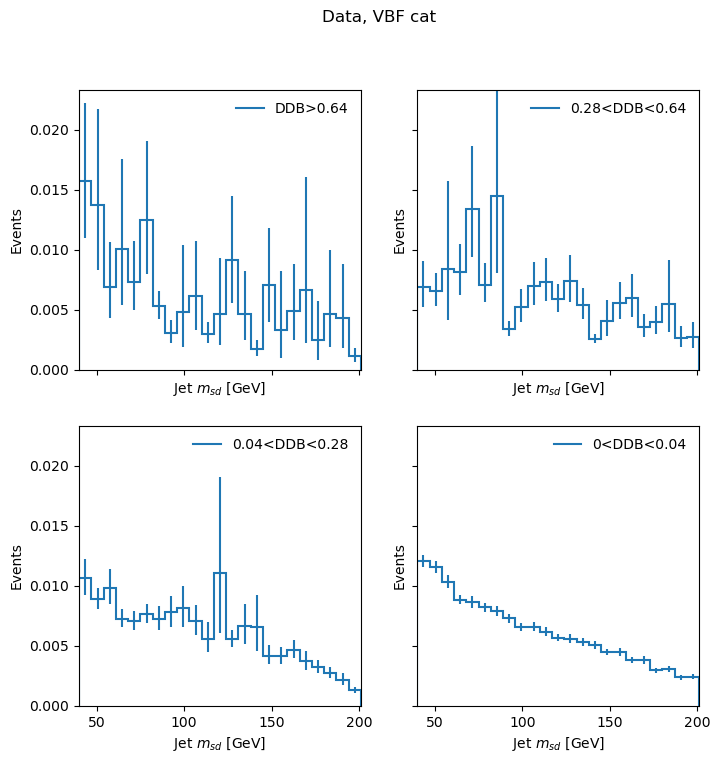

In [9]:
msdbins = np.linspace(40,201,23)
fig, ax = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,8))
plt.suptitle('Data, VBF cat')

hist.plot1d(templates_vbf.integrate('ddb1',int_range=slice(0.64,1)),ax=ax[0,0],legend_opts={'labels':['DDB>0.64'],'frameon':False},density=True)
hist.plot1d(templates_vbf.integrate('ddb1',int_range=slice(0.28,0.64)),ax=ax[0,1],legend_opts={'labels':['0.28<DDB<0.64'],'frameon':False},density=True)
hist.plot1d(templates_vbf.integrate('ddb1',int_range=slice(0.04,0.28)),ax=ax[1,0],legend_opts={'labels':['0.04<DDB<0.28'],'frameon':False},density=True)
hist.plot1d(templates_vbf.integrate('ddb1',int_range=slice(0,0.04)),ax=ax[1,1],legend_opts={'labels':['0<DDB<0.04'],'frameon':False},density=True)


/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=ddb1) instance at 0x7f0990593850>: requested stop 0.5 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=ddb1) instance at 0x7f0990593850>: requested stop 0.7 between bin boundaries, no interpolation is performed
  warnings.warn(


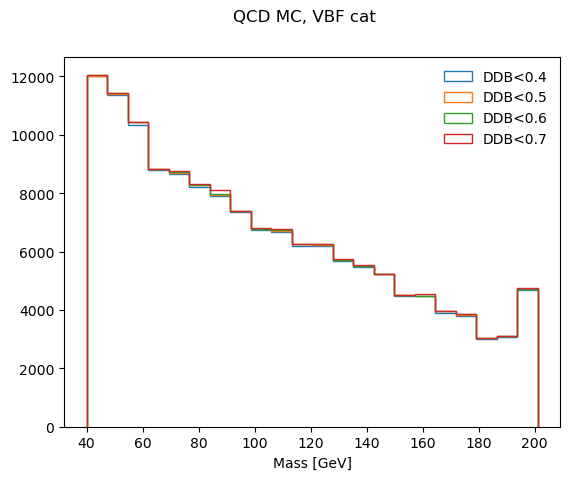

In [10]:
msdbins = np.linspace(40,201,23)
plt.hist(x=msdbins,weights=templates_vbf.integrate('ddb1',int_range=slice(0,0.4)).values()[()],bins=msdbins,histtype='step',label='DDB<0.4');
plt.hist(x=msdbins,weights=templates_vbf.integrate('ddb1',int_range=slice(0,0.5)).values()[()],bins=msdbins,histtype='step',label='DDB<0.5');
plt.hist(x=msdbins,weights=templates_vbf.integrate('ddb1',int_range=slice(0,0.6)).values()[()],bins=msdbins,histtype='step',label='DDB<0.6');
plt.hist(x=msdbins,weights=templates_vbf.integrate('ddb1',int_range=slice(0,0.7)).values()[()],bins=msdbins,histtype='step',label='DDB<0.7');
plt.xlabel('Mass [GeV]')
plt.suptitle('QCD MC, VBF cat')
plt.legend(frameon=False)

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:631: RuntimeWarning: Reducing along axis <Bin (name=ddb1) instance at 0x7f0990593850>: requested start 0.5 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:631: RuntimeWarning: Reducing along axis <Bin (name=ddb1) instance at 0x7f0990593850>: requested start 0.7 between bin boundaries, no interpolation is performed
  warnings.warn(


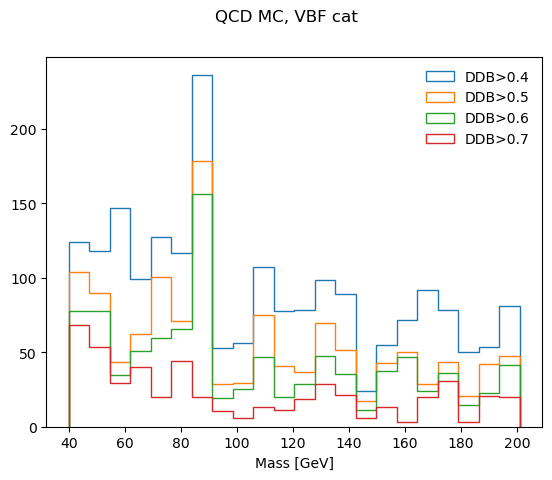

In [11]:
msdbins = np.linspace(40,201,23)
plt.hist(x=msdbins,weights=templates_vbf.integrate('ddb1',int_range=slice(0.4,1)).values()[()],bins=msdbins,histtype='step',label='DDB>0.4');
plt.hist(x=msdbins,weights=templates_vbf.integrate('ddb1',int_range=slice(0.5,1)).values()[()],bins=msdbins,histtype='step',label='DDB>0.5');
plt.hist(x=msdbins,weights=templates_vbf.integrate('ddb1',int_range=slice(0.6,1)).values()[()],bins=msdbins,histtype='step',label='DDB>0.6');
plt.hist(x=msdbins,weights=templates_vbf.integrate('ddb1',int_range=slice(0.7,1)).values()[()],bins=msdbins,histtype='step',label='DDB>0.7');
plt.xlabel('Mass [GeV]')
plt.suptitle('QCD MC, VBF cat')
plt.legend(frameon=False)

In [12]:
templates_ggf = templates.integrate('region','signal-ggf').integrate('process','data').sum('pt1')
templates_vbf = templates.integrate('region','signal-vbf').integrate('process','data').sum('pt1')

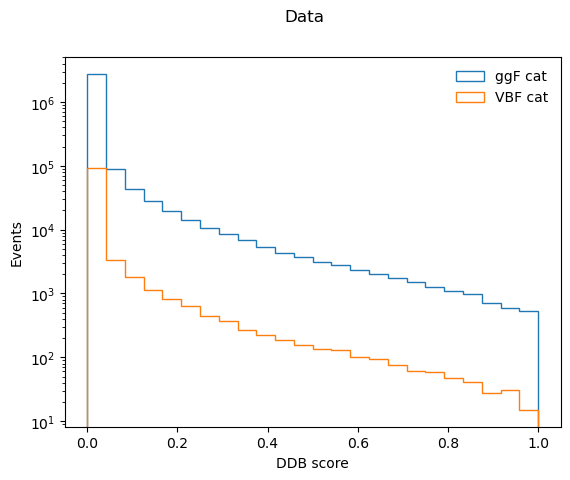

In [13]:
ddbbins = np.linspace(0,1,25)
plt.hist(x=ddbbins,weights=templates_ggf.sum('msd1').values()[()],bins=ddbbins,histtype='step',label='ggF cat');
plt.hist(x=ddbbins,weights=templates_vbf.sum('msd1').values()[()],bins=ddbbins,histtype='step',label='VBF cat');
plt.yscale('log')
plt.ylabel('Events')
plt.xlabel('DDB score')
plt.suptitle('Data')

plt.legend(frameon=False)

In [14]:
templates_vbf.integrate('ddb1',int_range=slice(0.64,1)).sum('msd1').values()[()]

357.0

In [15]:
templates_vbf.integrate('ddb1',int_range=slice(0.28,0.64)).sum('msd1').values()[()]

1656.0

In [16]:
templates_vbf.integrate('ddb1',int_range=slice(0.04,0.28)).sum('msd1').values()[()]

8200.0

In [17]:
templates_vbf.integrate('ddb1',int_range=slice(0,0.04)).sum('msd1').values()[()]

92287.0

<AxesSubplot: xlabel='Jet $m_{sd}$ [GeV]', ylabel='Events'>

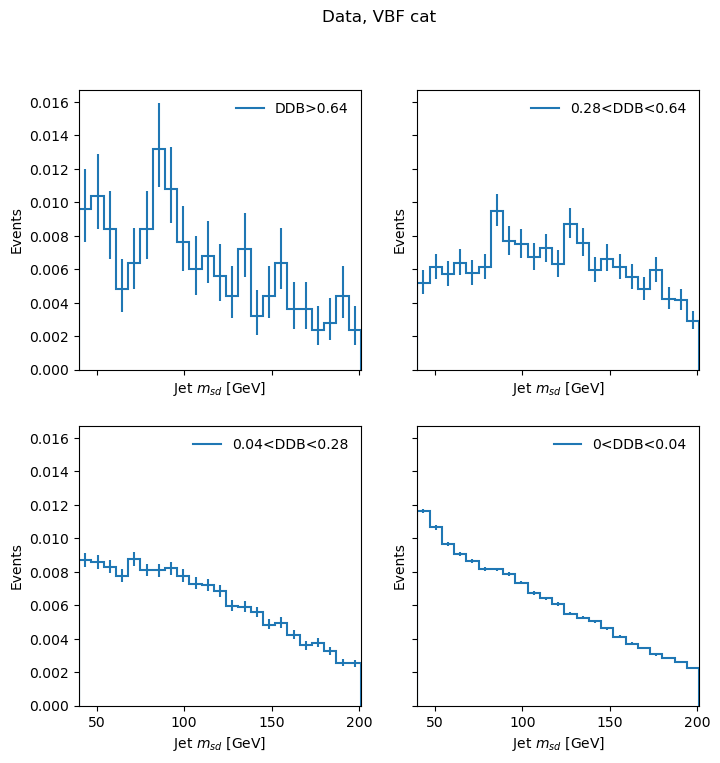

In [18]:
msdbins = np.linspace(40,201,23)
fig, ax = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,8))
plt.suptitle('Data, VBF cat')

hist.plot1d(templates_vbf.integrate('ddb1',int_range=slice(0.64,1)),ax=ax[0,0],legend_opts={'labels':['DDB>0.64'],'frameon':False},density=True)
hist.plot1d(templates_vbf.integrate('ddb1',int_range=slice(0.28,0.64)),ax=ax[0,1],legend_opts={'labels':['0.28<DDB<0.64'],'frameon':False},density=True)
hist.plot1d(templates_vbf.integrate('ddb1',int_range=slice(0.04,0.28)),ax=ax[1,0],legend_opts={'labels':['0.04<DDB<0.28'],'frameon':False},density=True)
hist.plot1d(templates_vbf.integrate('ddb1',int_range=slice(0,0.04)),ax=ax[1,1],legend_opts={'labels':['0<DDB<0.04'],'frameon':False},density=True)



/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=ddb1) instance at 0x7f0990593850>: requested stop 0.5 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=ddb1) instance at 0x7f0990593850>: requested stop 0.7 between bin boundaries, no interpolation is performed
  warnings.warn(


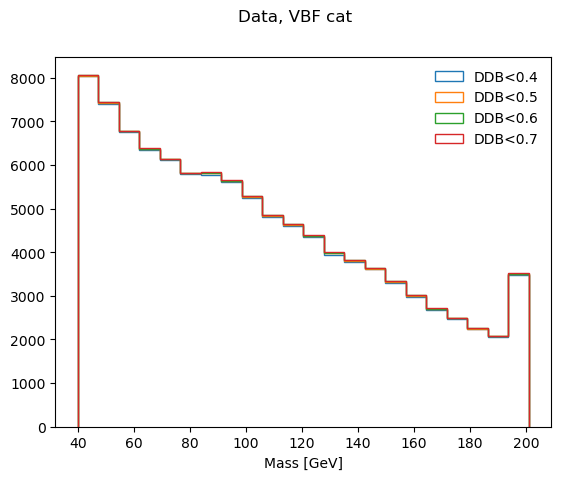

In [19]:
msdbins = np.linspace(40,201,23)
plt.hist(x=msdbins,weights=templates_vbf.integrate('ddb1',int_range=slice(0,0.4)).values()[()],bins=msdbins,histtype='step',label='DDB<0.4');
plt.hist(x=msdbins,weights=templates_vbf.integrate('ddb1',int_range=slice(0,0.5)).values()[()],bins=msdbins,histtype='step',label='DDB<0.5');
plt.hist(x=msdbins,weights=templates_vbf.integrate('ddb1',int_range=slice(0,0.6)).values()[()],bins=msdbins,histtype='step',label='DDB<0.6');
plt.hist(x=msdbins,weights=templates_vbf.integrate('ddb1',int_range=slice(0,0.7)).values()[()],bins=msdbins,histtype='step',label='DDB<0.7');
plt.xlabel('Mass [GeV]')
plt.suptitle('Data, VBF cat')
plt.legend(frameon=False)

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:631: RuntimeWarning: Reducing along axis <Bin (name=ddb1) instance at 0x7f0990593850>: requested start 0.5 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:631: RuntimeWarning: Reducing along axis <Bin (name=ddb1) instance at 0x7f0990593850>: requested start 0.7 between bin boundaries, no interpolation is performed
  warnings.warn(


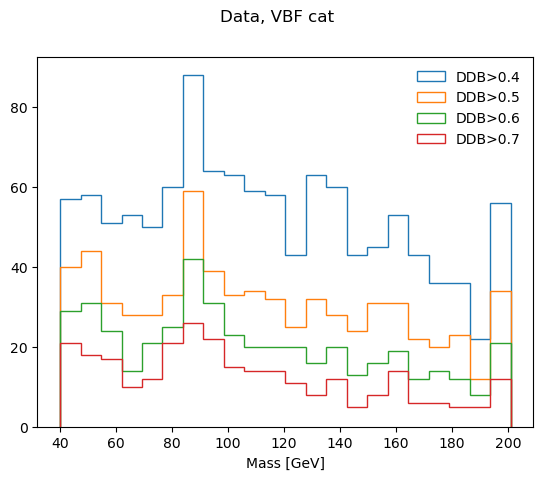

In [20]:
msdbins = np.linspace(40,201,23)
plt.hist(x=msdbins,weights=templates_vbf.integrate('ddb1',int_range=slice(0.4,1)).values()[()],bins=msdbins,histtype='step',label='DDB>0.4');
plt.hist(x=msdbins,weights=templates_vbf.integrate('ddb1',int_range=slice(0.5,1)).values()[()],bins=msdbins,histtype='step',label='DDB>0.5');
plt.hist(x=msdbins,weights=templates_vbf.integrate('ddb1',int_range=slice(0.6,1)).values()[()],bins=msdbins,histtype='step',label='DDB>0.6');
plt.hist(x=msdbins,weights=templates_vbf.integrate('ddb1',int_range=slice(0.7,1)).values()[()],bins=msdbins,histtype='step',label='DDB>0.7');
plt.xlabel('Mass [GeV]')
plt.suptitle('Data, VBF cat')
plt.legend(frameon=False)